In [1]:
import rasterio as rio, matplotlib.pyplot as plt, pandas as pd, geopandas as gpd, rioxarray, numpy as np, os, itertools
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from geocube.api.core import make_geocube
from adjustText import adjust_text
from scipy.spatial import cKDTree
from rasterio.plot import show
from osgeo import gdal

# Interpolate Meteo data

## Read the meteo data

In [2]:
dem = rio.open('DEM/Emilia-Romagna1.tif')

In [3]:
wind_data = pd.read_csv('Storico meteo/Processed_data/wind_stations_variables.csv')

# Utilizzare il metodo drop per rimuovere una colonna
wind_data = wind_data.drop('Unnamed: 0', axis=1)  # Rimuovi la colonna 'A'

In [4]:
wind_data

,name,lon,lat,h_sea,h_bar,B10004,B11001,B11002,B12101,B13003,B13011,date,year,month_name,B12101_C
0,Colorno,44.94378,10.34959,29.0,29.0,98427.621220,244.0,1.9,270.55,87.000000,0.000000,2012-01-01 00:00:00+00:00,2012,January,-2.6
1,Colorno,44.94378,10.34959,29.0,29.0,98431.869231,292.0,0.3,271.05,84.000000,0.000000,2012-01-01 01:00:00+00:00,2012,January,-2.1
2,Colorno,44.94378,10.34959,29.0,29.0,98414.845201,44.0,0.9,270.35,87.000000,0.000000,2012-01-01 02:00:00+00:00,2012,January,-2.8
3,Colorno,44.94378,10.34959,29.0,29.0,98421.233210,114.0,1.3,270.45,87.000000,0.000000,2012-01-01 03:00:00+00:00,2012,January,-2.7
4,Colorno,44.94378,10.34959,29.0,29.0,98475.914610,153.0,0.0,270.15,95.000000,0.000000,2012-01-01 04:00:00+00:00,2012,January,-3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2860830,Cesenatico porto,44.20645,12.40132,1.0,1.0,98993.283962,310.0,4.7,281.55,77.048417,0.124842,2021-01-31 19:00:00+00:00,2021,January,8.4
2860831,Cesenatico porto,44.20645,12.40132,1.0,1.0,99003.753637,309.0,4.3,281.75,76.758927,0.123831,2021-01-31 20:00:00+00:00,2021,January,8.6
2860832,Cesenatico porto,44.20645,12.40132,1.0,1.0,98961.874935,313.0,3.3,280.95,77.916887,0.127876,2021-01-31 21:00:00+00:00,2021,January,7.8
2860833,Cesenatico porto,44.20645,12.40132,1.0,1.0,98967.109773,303.0,4.9,281.05,77.772142,0.127371,2021-01-31 22:00:00+00:00,2021,January,7.9


### Get an unique value for each meteo station

In [5]:
# Filter the first element for 'lon', 'lat', and 'h_sea' for each unique value in the 'name' column
df_stations = wind_data.groupby('name').agg({
    'lon': 'first',
    'lat': 'first',
    'h_sea': 'first'
}).reset_index()

In [6]:
# Create a GeoDataFrame using EPSG 4326 coordinate reference system
gdf_stations = gpd.GeoDataFrame(df_stations, geometry=gpd.points_from_xy(df_stations.lat, df_stations.lon), crs='EPSG:4326')

gdf_stations = gdf_stations.to_crs(32632)

# Calcola le coordinate (x, y) dei centroidi in una singola riga
gdf_stations['x'], gdf_stations['y'] = gdf_stations.geometry.centroid.x, gdf_stations.geometry.centroid.y

In [7]:
def resample_dem(input_dem_path, output_dem_path, target_resolution):
    with rio.open(input_dem_path) as src:
        profile = src.profile
        profile.update(width=int(src.width * src.res[0] / target_resolution),
                       height=int(src.height * src.res[1] / target_resolution),
                       transform=rio.Affine(target_resolution, 0, src.transform[2], 0, -target_resolution,
                                            src.transform[5]))

        with rio.open(output_dem_path, 'w', **profile) as dst:
            for i in range(1, src.count + 1):
                src_band = src.read(i)
                dst.write_band(i, src_band)

In [8]:
input_dem_path = 'DEM/Emilia-Romagna1.tif'
output_dem_path = 'DEM/dem_resample.tif'
target_resolution = 250

resample_dem(input_dem_path, output_dem_path, target_resolution)

In [9]:
dem_resample = rio.open(output_dem_path)

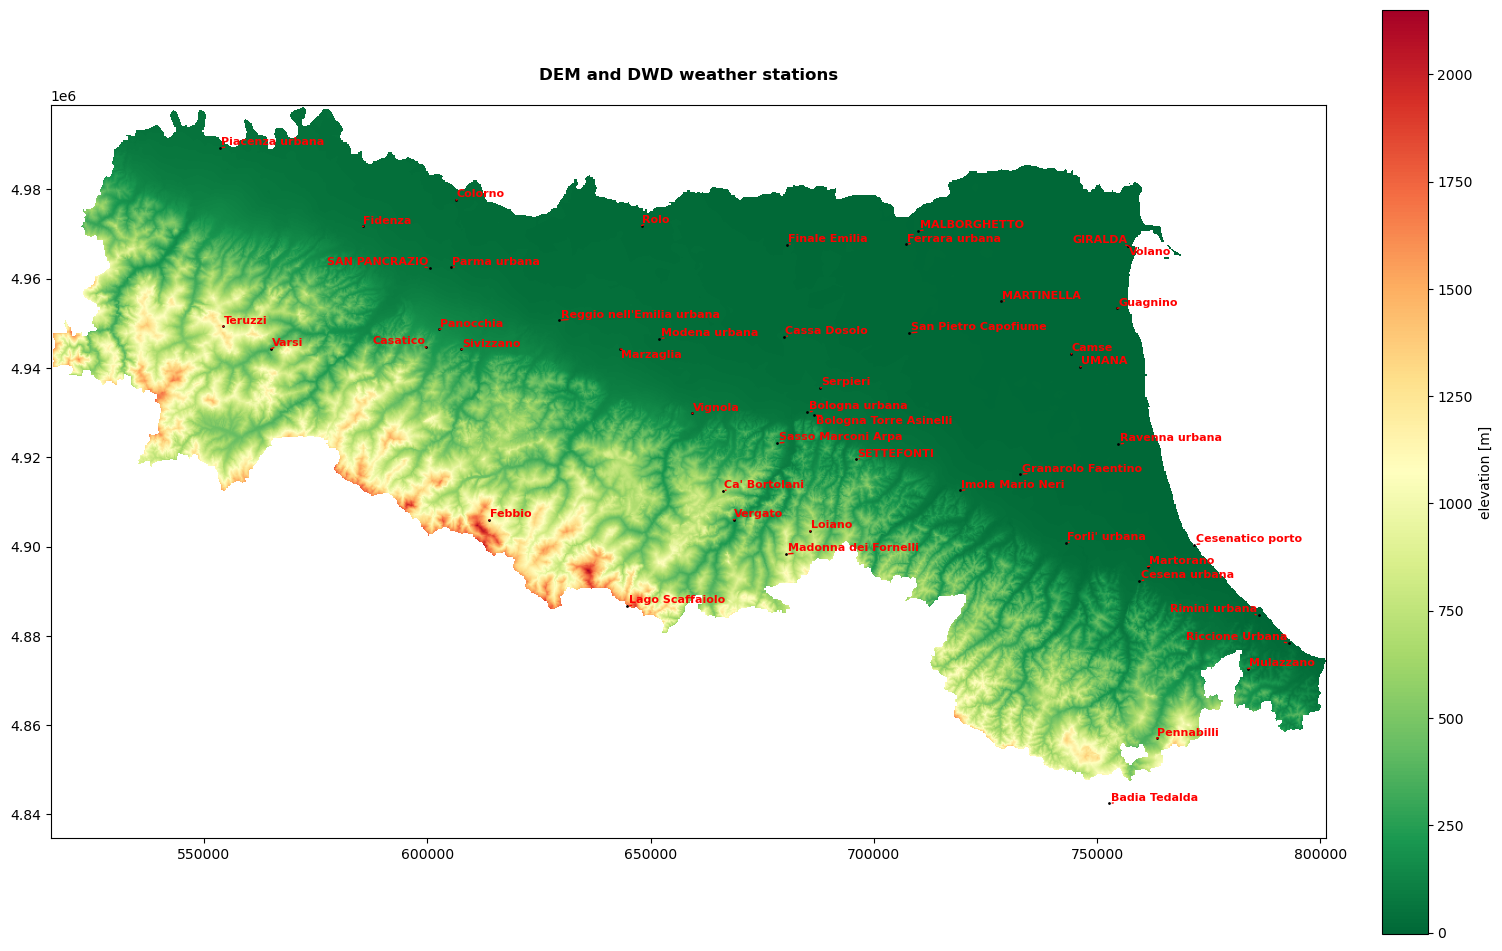

In [10]:
# Crea il tuo grafico
fig, ax = plt.subplots(figsize=(18, 12))

srtm_plot = show(
    dem_resample,
    ax=ax,
    cmap="RdYlGn_r",
    title="DEM and DWD weather stations\n",
)
gdf_stations.plot(ax=ax, markersize=1, color="black")

# Crea una lista di etichette per le stazioni meteorologiche con il testo in rosso
labels = [plt.text(x, y, name, fontsize=8, fontweight='bold', color='red') for x, y, name in zip(gdf_stations.geometry.x, gdf_stations.geometry.y, gdf_stations['name'])]

# Regola automaticamente le etichette per evitare sovrapposizioni senza frecce
adjust_text(labels, arrowprops=dict(arrowstyle='-', color='red'))

# Aggiungi la colorbar
dummy_colorbar = srtm_plot.get_images()[0]
cbar = fig.colorbar(dummy_colorbar, ax=ax, fraction=0.046, pad=0.04, label="elevation [m]")

plt.show()

## Load regioanl borders

In [11]:
read_regional_borders = gpd.read_file("Limiti01012023/Reg01012023/Reg01012023_WGS84.shp")
emilia_borders = read_regional_borders[read_regional_borders['DEN_REG'] == 'Emilia-Romagna']

## Transform raster pixels to gdf points

In [12]:
# Apre il file TIFF con rioxarray
rds = rioxarray.open_rasterio(output_dem_path)
rds.name = "data"

# Ottiene il valore di maschera dal raster
mask_value = rds.rio.nodata  # Questo restituirà il valore di maschera del raster

# Crea una maschera del raster basata sul valore di maschera
mask = rds.data != mask_value 

# Applica la maschera ai dati raster
rds_masked = rds.where(mask)

# Converte i dati raster mascherati in un DataFrame e crea una geometria di punti
df = rds_masked.squeeze().to_dataframe().reset_index()
geometry = gpd.points_from_xy(df.x, df.y)

# Crea il GeoDataFrame con i dati raster non mascherati
gdf = gpd.GeoDataFrame(df, crs=rds.rio.crs, geometry=geometry)

# Elimina le righe con valori NaN dalla colonna 'data'
gdf = gdf.dropna(subset=['data'])

In [13]:
gdf.rename(columns={'data': 'h_sea'}, inplace=True)

## Index calculation from DEM

In [14]:
gdal.DEMProcessing('Storico meteo/Indici_DEM/aspect.tif', output_dem_path, 'aspect')

gdal.DEMProcessing('Storico meteo/Indici_DEM/slope.tif', output_dem_path, 'slope')

def calculate_curvatures(dem, mask_value):
    rows, cols = dem.shape
    curvature_horizontal = np.full_like(dem, mask_value, dtype=np.float64)
    curvature_vertical = np.full_like(dem, mask_value, dtype=np.float64)

    # Calcola il gradiente in direzione x e y
    grad_y, grad_x = np.gradient(dem)
    grad_xx, grad_xy = np.gradient(grad_x)
    grad_yx, grad_yy = np.gradient(grad_y)

    # Applica limiti ai valori dei gradienti per prevenire l'overflow
    max_val = 1e5
    min_val = -1e5

    grad_xx = np.clip(grad_xx, min_val, max_val)
    grad_xy = np.clip(grad_xy, min_val, max_val)
    grad_yx = np.clip(grad_yx, min_val, max_val)
    grad_yy = np.clip(grad_yy, min_val, max_val)

    # Calcola le curvature con controlli sui valori di maschera
    for row in range(rows):
        for col in range(cols):
            if dem[row, col] == mask_value:
                continue  # Salta i valori di maschera

            curv_horiz = grad_xx[row, col] + grad_yy[row, col]
            curv_vert = grad_xx[row, col] * grad_yy[row, col] - (grad_xy[row, col] * grad_yx[row, col])**2

            # Applica limiti anche ai risultati delle curvature
            curvature_horizontal[row, col] = np.clip(curv_horiz, min_val, max_val)
            curvature_vertical[row, col] = np.clip(curv_vert, min_val, max_val)

    return curvature_horizontal, curvature_vertical

def calculate_tri(dem, mask_value, window_size=3):
    rows, cols = dem.shape
    tri = np.zeros_like(dem)

    for row in range(rows):
        for col in range(cols):
            if dem[row, col] == mask_value:
                tri[row, col] = mask_value
                continue

            window = dem[max(row - window_size // 2, 0):min(row + window_size // 2 + 1, rows),
                         max(col - window_size // 2, 0):min(col + window_size // 2 + 1, cols)]
            valid_data = window[window != mask_value]
            if valid_data.size > 0:
                tri[row, col] = np.max(valid_data) - np.min(valid_data)
            else:
                tri[row, col] = mask_value
    return tri

def calculate_tpi(dem, mask_value, window_size=3):
    rows, cols = dem.shape
    tpi = np.zeros_like(dem)

    for row in range(rows):
        for col in range(cols):
            if dem[row, col] == mask_value:
                tpi[row, col] = mask_value
                continue

            window = dem[max(row - window_size // 2, 0):min(row + window_size // 2 + 1, rows),
                         max(col - window_size // 2, 0):min(col + window_size // 2 + 1, cols)]
            valid_data = window[window != mask_value]
            if valid_data.size > 0:
                tpi[row, col] = dem[row, col] - valid_data.mean()
            else:
                tpi[row, col] = mask_value
    return tpi

with rio.open(output_dem_path) as src:
    dem = src.read(1)
    mask_value = src.nodata  # Ottiene il valore di maschera dal DEM

    # Calcola TRI, TPI e curvature
    tri = calculate_tri(dem, mask_value)
    tpi = calculate_tpi(dem, mask_value)
    curvature_horizontal, curvature_vertical = calculate_curvatures(dem, mask_value)

    src_meta = src.meta
    src_meta.update(dtype=rio.float32)

    # Salva il TRI
    with rio.open('Storico meteo/Indici_DEM/tri.tif', 'w', **src_meta) as dst:
        dst.write(tri.astype(rio.float32), 1)

    # Salva il TPI
    with rio.open('Storico meteo/Indici_DEM/tpi.tif', 'w', **src_meta) as dst:
        dst.write(tpi.astype(rio.float32), 1)

    # Salva la curvatura orizzontale
    with rio.open('Storico meteo/Indici_DEM/curvature_horizontal.tif', 'w', **src_meta) as dst:
        dst.write(curvature_horizontal.astype(rio.float32), 1)

    # Salva la curvatura verticale
    with rio.open('Storico meteo/Indici_DEM/curvature_vertical.tif', 'w', **src_meta) as dst:
        dst.write(curvature_vertical.astype(rio.float32), 1)

C:\Users\niett\anaconda3\Lib\site-packages\numpy\lib\function_base.py:1238: RuntimeWarning: overflow encountered in subtract
  out[tuple(slice1)] = (f[tuple(slice4)] - f[tuple(slice2)]) / (2. * ax_dx)


In [15]:
# Funzione per estrarre i valori del raster per i punti nel GeoDataFrame
def get_raster_values_for_points(gdf, raster_path, column_name):
    with rio.open(raster_path) as raster:
        # Assicurati che il GeoDataFrame e il raster abbiano lo stesso CRS
        if gdf.crs != raster.crs:
            gdf = gdf.to_crs(raster.crs)
        # Estrai i valori del raster per ogni punto
        coordinates = [(x, y) for x, y in zip(gdf.geometry.x, gdf.geometry.y)]
        gdf[column_name] = [x[0] for x in rio.sample.sample_gen(raster, coordinates)]
    return gdf

# Percorsi dei file raster
aspect_path = 'Storico meteo/Indici_DEM/aspect.tif'
slope_path = 'Storico meteo/Indici_DEM/slope.tif'
tri_path = 'Storico meteo/Indici_DEM/tri.tif'
tpi_path = 'Storico meteo/Indici_DEM/tpi.tif'
curv_horiz_path = 'Storico meteo/Indici_DEM/curvature_horizontal.tif'
curv_vert_path = 'Storico meteo/Indici_DEM/curvature_vertical.tif'

# Aggiungi i valori dei raster al GeoDataFrame
gdf = get_raster_values_for_points(gdf, aspect_path, 'aspect')
gdf = get_raster_values_for_points(gdf, slope_path, 'slope')
gdf = get_raster_values_for_points(gdf, tri_path, 'tri')
gdf = get_raster_values_for_points(gdf, tpi_path, 'tpi')
gdf = get_raster_values_for_points(gdf, curv_horiz_path, 'curvature_horizontal')
gdf = get_raster_values_for_points(gdf, curv_vert_path, 'curvature_vertical')

## Statistics each 15 days

In [16]:
%%time

# Converti la colonna 'date' in un formato datetime
wind_data['date'] = pd.to_datetime(wind_data['date'])

# Inizializza una lista vuota per memorizzare i DataFrames
stats_by_station = []

# Raggruppa per stazione, anno, mese e giorno
for station_name, station_data in wind_data.groupby('name'):
    station_data['Year'] = station_data['date'].dt.year
    station_data['Month'] = station_data['date'].dt.month
    station_data['Day'] = station_data['date'].dt.day

    for year, year_data in station_data.groupby('Year'):
        for month, month_data in year_data.groupby('Month'):
            # Suddividi i dati in due intervalli (1-15 e 16-last)
            interval_1_15 = month_data[month_data['Day'] <= 15]
            interval_16_last = month_data[month_data['Day'] > 15]

            if not interval_1_15.empty:
                # Calcola statistiche per l'intervallo 1-15
                interval_stats = interval_1_15[['B10004', 'B11001', 'B11002', 'B12101_C', 'B13003', 'B13011']].agg(['min', 'max', 'mean', 'std', 'median', lambda x: x.mode().iloc[0] if not x.empty else None, 'sum', 'count'])
                interval_stats = interval_stats.transpose()
                interval_stats['Year'] = year
                interval_stats['Month'] = month
                interval_stats['Interval'] = '1-15'
                interval_stats['name'] = station_name
                station_info = interval_1_15.iloc[0][['lat', 'lon', 'h_sea']]
                interval_stats['lat'] = station_info['lat']
                interval_stats['lon'] = station_info['lon']
                interval_stats['h_sea'] = station_info['h_sea']
                stats_by_station.append(interval_stats)

            if not interval_16_last.empty:
                # Calcola statistiche per l'intervallo 16-last
                interval_stats = interval_16_last[['B10004', 'B11001', 'B11002', 'B12101_C', 'B13003', 'B13011']].agg(['min', 'max', 'mean', 'std', 'median', lambda x: x.mode().iloc[0] if not x.empty else None, 'sum', 'count'])
                interval_stats = interval_stats.transpose()
                interval_stats['Year'] = year
                interval_stats['Month'] = month
                interval_stats['Interval'] = '16-last'
                interval_stats['name'] = station_name
                station_info = interval_16_last.iloc[0][['lat', 'lon', 'h_sea']]
                interval_stats['lat'] = station_info['lat']
                interval_stats['lon'] = station_info['lon']
                interval_stats['h_sea'] = station_info['h_sea']
                stats_by_station.append(interval_stats)

# Concatena la lista di DataFrames in un unico DataFrame
stats_by_station = pd.concat(stats_by_station)

# Rinomina la colonna "<lambda>" in "mode"
stats_by_station = stats_by_station.rename(columns={"<lambda>": "mode"})

CPU times: total: 44.3 s
Wall time: 1min 22s


In [17]:
stats_by_station

,min,max,mean,std,median,mode,sum,count,Year,Month,Interval,name,lat,lon,h_sea
B10004,89830.000000,93260.000000,92037.815126,687.862868,91990.000000,91890.000000,3.285750e+07,357.0,2012,1,1-15,Badia Tedalda,12.13623,43.69223,850.0
B11001,0.000000,353.000000,167.526611,94.008083,208.000000,238.000000,5.980700e+04,357.0,2012,1,1-15,Badia Tedalda,12.13623,43.69223,850.0
B11002,0.100000,5.600000,1.948179,0.944070,1.900000,1.900000,6.955000e+02,357.0,2012,1,1-15,Badia Tedalda,12.13623,43.69223,850.0
B12101_C,-1.600000,10.000000,3.577871,2.220927,3.500000,2.900000,1.277300e+03,357.0,2012,1,1-15,Badia Tedalda,12.13623,43.69223,850.0
B13003,72.817046,112.583278,82.377806,3.651428,82.337644,78.476261,2.940888e+04,357.0,2012,1,1-15,Badia Tedalda,12.13623,43.69223,850.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B11001,321.000000,321.000000,321.000000,NaN,321.000000,321.000000,3.210000e+02,1.0,2012,1,1-15,Volano,12.25037,44.81287,1.0
B11002,0.500000,0.500000,0.500000,NaN,0.500000,0.500000,5.000000e-01,1.0,2012,1,1-15,Volano,12.25037,44.81287,1.0
B12101_C,-2.700000,-2.700000,-2.700000,NaN,-2.700000,-2.700000,-2.700000e+00,1.0,2012,1,1-15,Volano,12.25037,44.81287,1.0
B13003,88.000000,88.000000,88.000000,NaN,88.000000,88.000000,8.800000e+01,1.0,2012,1,1-15,Volano,12.25037,44.81287,1.0


In [20]:
stats_by_station[stats_by_station.index.isin(['B11002'])]

,min,max,mean,std,median,mode,sum,count,Year,Month,Interval,name,lat,lon,h_sea
B11002,0.1,5.6,1.948179,0.944070,1.9,1.9,695.5,357.0,2012,1,1-15,Badia Tedalda,12.13623,43.69223,850.0
B11002,0.1,4.6,2.028869,0.931841,1.9,1.4,681.7,336.0,2012,1,16-last,Badia Tedalda,12.13623,43.69223,850.0
B11002,1.3,3.5,2.572727,0.579147,2.5,2.4,56.6,22.0,2012,2,1-15,Badia Tedalda,12.13623,43.69223,850.0
B11002,0.1,6.6,2.118976,1.079093,2.1,2.5,703.5,332.0,2012,2,16-last,Badia Tedalda,12.13623,43.69223,850.0
B11002,0.1,7.7,2.650278,1.588977,2.2,1.8,954.1,360.0,2012,3,1-15,Badia Tedalda,12.13623,43.69223,850.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B11002,0.0,6.0,1.428767,0.773572,1.4,1.4,417.2,292.0,2021,2,16-last,Vignola,11.00414,44.50405,100.0
B11002,0.0,8.4,1.921170,1.311955,1.6,1.6,689.7,359.0,2021,3,1-15,Vignola,11.00414,44.50405,100.0
B11002,0.0,7.5,1.675781,1.198764,1.6,0.0,643.5,384.0,2021,3,16-last,Vignola,11.00414,44.50405,100.0
B11002,0.0,6.1,1.963780,1.169519,1.8,0.0,498.8,254.0,2021,4,1-15,Vignola,11.00414,44.50405,100.0


## DF totale

In [18]:
# Select rows 
day_data = stats_by_station[stats_by_station.index.isin(['B10004', 'B11001', 'B11002', 'B12101_C', 'B13003', 'B13011'])]

# Reset the index to move the station names from the index to columns
day_data = day_data.reset_index()

# Pivot the DataFrame in columns 
pivoted_data = day_data.pivot_table(index=['name', 'lat', 'lon', 'h_sea', 'Year', 'Month', 'Interval'], columns='index', values='mean')

# Reset the index for the final DataFrame
pivoted_data = pivoted_data.reset_index()

In [19]:
pivoted_data

index,name,lat,lon,h_sea,Year,Month,Interval,B10004,B11001,B11002,B12101_C,B13003,B13011
0,Badia Tedalda,12.13623,43.69223,850.0,2012,1,1-15,92037.815126,167.526611,1.948179,3.577871,82.377806,0.107003
1,Badia Tedalda,12.13623,43.69223,850.0,2012,1,16-last,92030.476190,168.142857,2.028869,1.841369,84.459354,0.001190
2,Badia Tedalda,12.13623,43.69223,850.0,2012,2,1-15,91004.090909,222.181818,2.572727,-3.440909,91.829441,0.000000
3,Badia Tedalda,12.13623,43.69223,850.0,2012,2,16-last,92153.524096,164.036145,2.118976,3.501506,82.637358,0.138554
4,Badia Tedalda,12.13623,43.69223,850.0,2012,3,1-15,92342.583333,120.816667,2.650278,6.194167,78.451580,0.048889
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8139,Vignola,11.00414,44.50405,100.0,2021,2,16-last,101642.157534,196.931507,1.428767,9.202397,67.380137,0.000000
8140,Vignola,11.00414,44.50405,100.0,2021,3,1-15,100791.364903,170.576602,1.921170,8.572423,56.164345,0.007242
8141,Vignola,11.00414,44.50405,100.0,2021,3,16-last,100931.432292,164.130208,1.675781,9.545313,47.242188,0.000000
8142,Vignola,11.00414,44.50405,100.0,2021,4,1-15,100437.598425,165.133858,1.963780,10.648031,53.425197,0.092126


In [20]:
# Create a GeoDataFrame using EPSG 4326 coordinate reference system
gdf_selection_data = gpd.GeoDataFrame(pivoted_data, geometry=gpd.points_from_xy(pivoted_data.lat, pivoted_data.lon), crs='EPSG:4326')

gdf_selection_data = gdf_selection_data.to_crs(32632)

# Calcola le coordinate (x, y) dei centroidi in una singola riga
gdf_selection_data['x'], gdf_selection_data[
    'y'] = gdf_selection_data.geometry.centroid.x, gdf_selection_data.geometry.centroid.y

In [21]:
gdf_selection_data

index,name,lat,lon,h_sea,Year,Month,Interval,B10004,B11001,B11002,B12101_C,B13003,B13011,geometry,x,y
0,Badia Tedalda,12.13623,43.69223,850.0,2012,1,1-15,92037.815126,167.526611,1.948179,3.577871,82.377806,0.107003,POINT (752746.515 4842471.291),752746.514576,4.842471e+06
1,Badia Tedalda,12.13623,43.69223,850.0,2012,1,16-last,92030.476190,168.142857,2.028869,1.841369,84.459354,0.001190,POINT (752746.515 4842471.291),752746.514576,4.842471e+06
2,Badia Tedalda,12.13623,43.69223,850.0,2012,2,1-15,91004.090909,222.181818,2.572727,-3.440909,91.829441,0.000000,POINT (752746.515 4842471.291),752746.514576,4.842471e+06
3,Badia Tedalda,12.13623,43.69223,850.0,2012,2,16-last,92153.524096,164.036145,2.118976,3.501506,82.637358,0.138554,POINT (752746.515 4842471.291),752746.514576,4.842471e+06
4,Badia Tedalda,12.13623,43.69223,850.0,2012,3,1-15,92342.583333,120.816667,2.650278,6.194167,78.451580,0.048889,POINT (752746.515 4842471.291),752746.514576,4.842471e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8139,Vignola,11.00414,44.50405,100.0,2021,2,16-last,101642.157534,196.931507,1.428767,9.202397,67.380137,0.000000,POINT (659314.204 4929812.541),659314.204122,4.929813e+06
8140,Vignola,11.00414,44.50405,100.0,2021,3,1-15,100791.364903,170.576602,1.921170,8.572423,56.164345,0.007242,POINT (659314.204 4929812.541),659314.204122,4.929813e+06
8141,Vignola,11.00414,44.50405,100.0,2021,3,16-last,100931.432292,164.130208,1.675781,9.545313,47.242188,0.000000,POINT (659314.204 4929812.541),659314.204122,4.929813e+06
8142,Vignola,11.00414,44.50405,100.0,2021,4,1-15,100437.598425,165.133858,1.963780,10.648031,53.425197,0.092126,POINT (659314.204 4929812.541),659314.204122,4.929813e+06


### Set the distance weights

In [22]:
# Crea una colonna 'average_distance' per la distanza media
gdf_selection_data['average_distance'] = 0.0

# Crea un albero cKDTree basato sulle coordinate dei punti
tree = cKDTree(list(gdf_selection_data['geometry'].apply(lambda geom: (geom.x, geom.y))))

# Calcola la distanza media per ciascun punto
for idx, row in gdf_selection_data.iterrows():
    point = row['geometry']
    # Trova i punti più vicini escluso il punto stesso
    distances, _ = tree.query([point.x, point.y], k=len(gdf_selection_data) - 1)
    # Calcola la distanza media basata sui punti più vicini
    average_distance = sum(distances) / (len(gdf_selection_data) - 1)
    gdf_selection_data.at[idx, 'average_distance'] = average_distance

C:\Users\niett\anaconda3\Lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


In [23]:
# Crea una nuova colonna 'normalized_distance' con i valori normalizzati di 'average_distance'
scaler = MinMaxScaler()
gdf_selection_data['normalized_distance'] = scaler.fit_transform(gdf_selection_data[['average_distance']])

# Calcola l'inverso della colonna 'normalized_distance'
max_value = gdf_selection_data['normalized_distance'].max()
gdf_selection_data['inverted_distance'] = max_value - gdf_selection_data['normalized_distance']

In [24]:
try:
    # Rinomina le colonne 'index_left' e 'index_right' se presenti
    if 'index_left' in gdf_selection_data.columns:
        gdf_selection_data = gdf_selection_data.rename(columns={'index_left': 'index_left_old'})
    if 'index_right' in gdf_selection_data.columns:
        gdf_selection_data = gdf_selection_data.rename(columns={'index_right': 'index_right_old'})

    if 'index_left' in gdf.columns:
        gdf = gdf.rename(columns={'index_left': 'index_left_old'})
    if 'index_right' in gdf.columns:
        gdf = gdf.rename(columns={'index_right': 'index_right_old'})

    # Assicurati che entrambi i GeoDataFrame abbiano un sistema di coordinate (CRS) compatibile
    if gdf.crs != gdf_selection_data.crs:
        gdf_selection_data = gdf_selection_data.to_crs(gdf.crs)

except:
    print("No need to rename")
# Esegui un join spaziale usando sjoin_nearest
gdf_selection_data = gpd.sjoin_nearest(gdf_selection_data, gdf, how='left')

## Wind speed prediction

In [25]:
gdf_selection_data.rename(columns={'y_left': 'y', 'x_left': 'x', 'h_sea_left': 'h_sea'}, inplace=True)

# Estrai le colonne di interesse dal GeoDataFrame
columns = ['y', 'x', 'h_sea', 'aspect', 'slope', 'tri', 'tpi', 'curvature_horizontal', 'curvature_vertical', 'B11002',
           'inverted_distance']

data = gdf_selection_data[columns]

# Rimuovi le righe con valori mancanti
data = data.dropna()

### Calculate the best model for all the periods and years

In [29]:
# Genera tutte le possibili combinazioni di variabili
variable_names = ['h_sea', 'aspect', 'slope', 'tri', 'tpi', 'curvature_horizontal', 'curvature_vertical']
all_combinations = []
for r in range(1, len(variable_names) + 1):
    for subset in itertools.combinations(variable_names, r):
        all_combinations.append(list(subset))

# Imposta la cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_r2 = -float('inf')
best_mse = float('inf')
best_combination = None
model_name = 'RandomForestRegressor'

total_combinations = len(all_combinations)
current_combination = 0
results = []

for combination in all_combinations:
    current_combination += 1
    r2_scores = []
    mse_scores = []

    print(f"Analizzando la combinazione {current_combination} di {total_combinations}: {combination}")

    fold_number = 0
    for train_index, test_index in kf.split(data):
        fold_number += 1
        print(f"  - Cross-validation, iterazione {fold_number}/{kf.get_n_splits()}")

        X_train, X_test = data.iloc[train_index][combination], data.iloc[test_index][combination]
        y_train, y_test = data.iloc[train_index]['B11002'], data.iloc[test_index]['B11002']
        weights_train, weights_test = data.iloc[train_index]['inverted_distance'], data.iloc[test_index]['inverted_distance']

        rf_model = RandomForestRegressor(n_estimators=5000, random_state=42)
        rf_model.fit(X_train, y_train, sample_weight=weights_train)

        y_pred_rf = rf_model.predict(X_test)
        r2_scores.append(r2_score(y_test, y_pred_rf))
        mse_scores.append(mean_squared_error(y_test, y_pred_rf))

    avg_r2 = sum(r2_scores) / len(r2_scores)
    avg_mse = sum(mse_scores) / len(mse_scores)

    print(f"  - R² medio: {avg_r2}, MSE medio: {avg_mse}")

    # Aggiungi i risultati alla lista
    results.append({
        'combination': combination,
        'model': model_name,
        'avg_r2': avg_r2,
        'avg_mse': avg_mse
    })

    if avg_r2 > best_r2 and avg_mse < best_mse:
        best_r2 = avg_r2
        best_mse = avg_mse
        best_combination = combination

# Crea un DataFrame dai risultati
results_df = pd.DataFrame(results)

# Salva il DataFrame come CSV
results_df.to_csv('Storico meteo/model_results_wind_speed.csv', index=False)

print(f'Migliore combinazione di variabili: {best_combination}')
print(f'Miglior R² medio: {best_r2}')
print(f'Miglior MSE medio: {best_mse}')

Analizzando la combinazione 1 di 1: ['h_sea']
  - Cross-validation, iterazione 1/5


KeyboardInterrupt: 

### Predict each month every 15 days in one loop

In [26]:
# List of months to consider
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]  # All months of the year
intervals = ['1-15', '16-last']  # Two possible intervals

for month in months:
    for interval in intervals:
        # Filter data based on the month and interval
        selection_data = pivoted_data[(pivoted_data['Month'] == month) & (pivoted_data['Interval'] == interval)].reset_index(drop=True)
        
        # Create a GeoDataFrame using EPSG 4326 coordinate reference system
        gdf_selection_data = gpd.GeoDataFrame(selection_data, geometry=gpd.points_from_xy(selection_data.lat, selection_data.lon), crs='EPSG:4326')
        
        # Transform coordinates to a different reference system if necessary
        gdf_selection_data = gdf_selection_data.to_crs(32632)
        
        # Calculate the (x, y) coordinates of centroids
        gdf_selection_data['x'], gdf_selection_data['y'] = gdf_selection_data.geometry.centroid.x, gdf_selection_data.geometry.centroid.y

        try:
            # Rinomina le colonne 'index_left' e 'index_right' se presenti
            if 'index_left' in gdf_selection_data.columns:
                gdf_selection_data = gdf_selection_data.rename(columns={'index_left': 'index_left_old'})
            if 'index_right' in gdf_selection_data.columns:
                gdf_selection_data = gdf_selection_data.rename(columns={'index_right': 'index_right_old'})
            if 'index_left' in gdf.columns:
                gdf = gdf.rename(columns={'index_left': 'index_left_old'})
            if 'index_right' in gdf.columns:
                gdf = gdf.rename(columns={'index_right': 'index_right_old'})

            # Assicurati che entrambi i GeoDataFrame abbiano un sistema di coordinate (CRS) compatibile
            if gdf.crs != gdf_selection_data.crs:
                gdf_selection_data = gdf_selection_data.to_crs(gdf.crs)

        except:
            print("No need to rename")
        
        # Esegui un join spaziale usando sjoin_nearest
        gdf_selection_data = gpd.sjoin_nearest(gdf_selection_data, gdf, how='left')
        gdf_selection_data.rename(columns={'y_left': 'y', 'x_left': 'x', 'h_sea_left': 'h_sea'}, inplace=True)
        
        # Create a column 'average_distance' for the average distance
        gdf_selection_data['average_distance'] = 0.0
        
        # Create a cKDTree based on point coordinates
        tree = cKDTree(list(gdf_selection_data['geometry'].apply(lambda geom: (geom.x, geom.y))))
        
        # Calculate the average distance for each point
        for idx, row in gdf_selection_data.iterrows():
            point = row['geometry']
            # Find the nearest points excluding the point itself
            distances, _ = tree.query([point.x, point.y], k=len(gdf_selection_data) - 1)
            # Calculate the average distance based on the nearest points
            average_distance = sum(distances) / (len(gdf_selection_data) - 1)
            gdf_selection_data.at[idx, 'average_distance'] = average_distance
        
        # Create a new column 'normalized_distance' with normalized values of 'average_distance'
        scaler = MinMaxScaler()
        gdf_selection_data['normalized_distance'] = scaler.fit_transform(gdf_selection_data[['average_distance']])
        
        # Calculate the inverse of the 'normalized_distance' column
        max_value = gdf_selection_data['normalized_distance'].max()
        gdf_selection_data['inverted_distance'] = max_value - gdf_selection_data['normalized_distance']
        
        # Extract columns of interest from the GeoDataFrame
        columns = ['h_sea', 'B11002', 'inverted_distance']
        data = gdf_selection_data[columns]
        
        # Replace NaN values with the mean of the respective columns
        data = data.fillna(data.mean())
        
        # Split the data into explanatory variables (X), target variable (y), and weights
        X = data[['h_sea']]
        y = data['B11002']
        weights = data['inverted_distance']
        
        # Split the data into training and test sets
        X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(X, y, weights, test_size=0.15, random_state=42)
        
        # Train a Random Forest model with weights
        rf_model = RandomForestRegressor(n_estimators=5000, random_state=42)
        rf_model.fit(X_train, y_train, sample_weight=weights_train)
        
        # Make predictions on the test set
        y_pred_rf = rf_model.predict(X_test)
        
        # Evaluate the performance of the Random Forest model
        r2_rf = r2_score(y_test, y_pred_rf)
        mse_rf = mean_squared_error(y_test, y_pred_rf)
        
        print(f'Month: {month}, Interval: {interval}')
        print(f'R² (Random Forest with weights): {r2_rf}')
        print(f'MSE (Random Forest with weights): {mse_rf}')
        
        # Prepare the data in the GeoDataFrame for making predictions
        X_predict = gdf[['h_sea']]
        
        # Use the Random Forest model to make predictions on 'B11002'
        predicted_B11002 = rf_model.predict(X_predict)  # Assume that rf_model is your trained Random Forest model
        
        # Add the predictions as a new column in your GeoDataFrame
        gdf[f'p_B11002_{month}_Interval_{interval}'] = predicted_B11002
        
        # Save the GeoDataFrame to a shapefile
        output_shapefile_filename = f"Storico meteo/Shapefile_export/predicted_B11002_{month}_Interval_{interval}.shp"
        gdf.to_file(output_shapefile_filename)
        
        # Create the raster with the name based on the month and interval
        out_grid = make_geocube(gdf, resolution=(target_resolution, target_resolution), measurements=[f'p_B11002_{month}_Interval_{interval}'])
        output_raster_filename = f"Storico meteo/Raster_export/predicted_B11002_{month}_Interval_{interval}.tif"
        out_grid[f'p_B11002_{month}_Interval_{interval}'].rio.to_raster(output_raster_filename)
        
        print(f"Saved {output_shapefile_filename} and {output_raster_filename}")

C:\Users\niett\anaconda3\Lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


Month: 1, Interval: 1-15
R² (Random Forest with weights): 0.7111787406969309
MSE (Random Forest with weights): 0.4145083827610269


C:\Users\niett\AppData\Local\Temp\ipykernel_11668\616335976.py:105: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(output_shapefile_filename)


Saved Storico meteo/Shapefile_export/predicted_B11002_1_Interval_1-15.shp and Storico meteo/Raster_export/predicted_B11002_1_Interval_1-15.tif


C:\Users\niett\anaconda3\Lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


Month: 1, Interval: 16-last
R² (Random Forest with weights): 0.7138650626878149
MSE (Random Forest with weights): 0.24734768785806258


C:\Users\niett\AppData\Local\Temp\ipykernel_11668\616335976.py:105: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(output_shapefile_filename)


Saved Storico meteo/Shapefile_export/predicted_B11002_1_Interval_16-last.shp and Storico meteo/Raster_export/predicted_B11002_1_Interval_16-last.tif


C:\Users\niett\anaconda3\Lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


Month: 2, Interval: 1-15
R² (Random Forest with weights): 0.6724836194520387
MSE (Random Forest with weights): 0.34435855811829313


C:\Users\niett\AppData\Local\Temp\ipykernel_11668\616335976.py:105: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(output_shapefile_filename)


Saved Storico meteo/Shapefile_export/predicted_B11002_2_Interval_1-15.shp and Storico meteo/Raster_export/predicted_B11002_2_Interval_1-15.tif


C:\Users\niett\anaconda3\Lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


Month: 2, Interval: 16-last
R² (Random Forest with weights): 0.5022781511799486
MSE (Random Forest with weights): 0.34384362709845706


C:\Users\niett\AppData\Local\Temp\ipykernel_11668\616335976.py:105: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(output_shapefile_filename)


Saved Storico meteo/Shapefile_export/predicted_B11002_2_Interval_16-last.shp and Storico meteo/Raster_export/predicted_B11002_2_Interval_16-last.tif


C:\Users\niett\anaconda3\Lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


Month: 3, Interval: 1-15
R² (Random Forest with weights): 0.7812008371956504
MSE (Random Forest with weights): 0.23739044645905177


C:\Users\niett\AppData\Local\Temp\ipykernel_11668\616335976.py:105: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(output_shapefile_filename)


Saved Storico meteo/Shapefile_export/predicted_B11002_3_Interval_1-15.shp and Storico meteo/Raster_export/predicted_B11002_3_Interval_1-15.tif


C:\Users\niett\anaconda3\Lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


Month: 3, Interval: 16-last
R² (Random Forest with weights): 0.8280190719418177
MSE (Random Forest with weights): 0.11893299538451381


C:\Users\niett\AppData\Local\Temp\ipykernel_11668\616335976.py:105: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(output_shapefile_filename)


Saved Storico meteo/Shapefile_export/predicted_B11002_3_Interval_16-last.shp and Storico meteo/Raster_export/predicted_B11002_3_Interval_16-last.tif


C:\Users\niett\anaconda3\Lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


Month: 4, Interval: 1-15
R² (Random Forest with weights): 0.7384682862580677
MSE (Random Forest with weights): 0.14701161474055802


C:\Users\niett\AppData\Local\Temp\ipykernel_11668\616335976.py:105: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(output_shapefile_filename)


Saved Storico meteo/Shapefile_export/predicted_B11002_4_Interval_1-15.shp and Storico meteo/Raster_export/predicted_B11002_4_Interval_1-15.tif


C:\Users\niett\anaconda3\Lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


Month: 4, Interval: 16-last
R² (Random Forest with weights): 0.3828017787012561
MSE (Random Forest with weights): 0.4425766545530335


C:\Users\niett\AppData\Local\Temp\ipykernel_11668\616335976.py:105: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(output_shapefile_filename)


Saved Storico meteo/Shapefile_export/predicted_B11002_4_Interval_16-last.shp and Storico meteo/Raster_export/predicted_B11002_4_Interval_16-last.tif


C:\Users\niett\anaconda3\Lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


Month: 5, Interval: 1-15
R² (Random Forest with weights): 0.4331517077305157
MSE (Random Forest with weights): 0.3796435413014242


C:\Users\niett\AppData\Local\Temp\ipykernel_11668\616335976.py:105: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(output_shapefile_filename)


Saved Storico meteo/Shapefile_export/predicted_B11002_5_Interval_1-15.shp and Storico meteo/Raster_export/predicted_B11002_5_Interval_1-15.tif


C:\Users\niett\anaconda3\Lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


Month: 5, Interval: 16-last
R² (Random Forest with weights): 0.47017703436436875
MSE (Random Forest with weights): 0.6853930310282704


C:\Users\niett\AppData\Local\Temp\ipykernel_11668\616335976.py:105: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(output_shapefile_filename)


Saved Storico meteo/Shapefile_export/predicted_B11002_5_Interval_16-last.shp and Storico meteo/Raster_export/predicted_B11002_5_Interval_16-last.tif


C:\Users\niett\anaconda3\Lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


Month: 6, Interval: 1-15
R² (Random Forest with weights): 0.5319065708175521
MSE (Random Forest with weights): 0.42716275562235173


C:\Users\niett\AppData\Local\Temp\ipykernel_11668\616335976.py:105: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(output_shapefile_filename)


Saved Storico meteo/Shapefile_export/predicted_B11002_6_Interval_1-15.shp and Storico meteo/Raster_export/predicted_B11002_6_Interval_1-15.tif


C:\Users\niett\anaconda3\Lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


Month: 6, Interval: 16-last
R² (Random Forest with weights): 0.7588798752915215
MSE (Random Forest with weights): 0.10807135889341583


C:\Users\niett\AppData\Local\Temp\ipykernel_11668\616335976.py:105: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(output_shapefile_filename)


Saved Storico meteo/Shapefile_export/predicted_B11002_6_Interval_16-last.shp and Storico meteo/Raster_export/predicted_B11002_6_Interval_16-last.tif


C:\Users\niett\anaconda3\Lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


Month: 7, Interval: 1-15
R² (Random Forest with weights): 0.4976193969200309
MSE (Random Forest with weights): 0.3723087049248745


C:\Users\niett\AppData\Local\Temp\ipykernel_11668\616335976.py:105: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(output_shapefile_filename)


Saved Storico meteo/Shapefile_export/predicted_B11002_7_Interval_1-15.shp and Storico meteo/Raster_export/predicted_B11002_7_Interval_1-15.tif


C:\Users\niett\anaconda3\Lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


Month: 7, Interval: 16-last
R² (Random Forest with weights): 0.7581894065706376
MSE (Random Forest with weights): 0.13674787964770574


C:\Users\niett\AppData\Local\Temp\ipykernel_11668\616335976.py:105: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(output_shapefile_filename)


Saved Storico meteo/Shapefile_export/predicted_B11002_7_Interval_16-last.shp and Storico meteo/Raster_export/predicted_B11002_7_Interval_16-last.tif


C:\Users\niett\anaconda3\Lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


Month: 8, Interval: 1-15
R² (Random Forest with weights): 0.7863703701725318
MSE (Random Forest with weights): 0.10585844791144139


C:\Users\niett\AppData\Local\Temp\ipykernel_11668\616335976.py:105: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(output_shapefile_filename)


Saved Storico meteo/Shapefile_export/predicted_B11002_8_Interval_1-15.shp and Storico meteo/Raster_export/predicted_B11002_8_Interval_1-15.tif


C:\Users\niett\anaconda3\Lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


Month: 8, Interval: 16-last
R² (Random Forest with weights): 0.8189423652765905
MSE (Random Forest with weights): 0.10252828631800368


C:\Users\niett\AppData\Local\Temp\ipykernel_11668\616335976.py:105: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(output_shapefile_filename)


Saved Storico meteo/Shapefile_export/predicted_B11002_8_Interval_16-last.shp and Storico meteo/Raster_export/predicted_B11002_8_Interval_16-last.tif


C:\Users\niett\anaconda3\Lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


Month: 9, Interval: 1-15
R² (Random Forest with weights): 0.6306095801504181
MSE (Random Forest with weights): 0.28207048312941657


C:\Users\niett\AppData\Local\Temp\ipykernel_11668\616335976.py:105: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(output_shapefile_filename)


Saved Storico meteo/Shapefile_export/predicted_B11002_9_Interval_1-15.shp and Storico meteo/Raster_export/predicted_B11002_9_Interval_1-15.tif


C:\Users\niett\anaconda3\Lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


Month: 9, Interval: 16-last
R² (Random Forest with weights): 0.7443354567920022
MSE (Random Forest with weights): 0.16881586088435205


C:\Users\niett\AppData\Local\Temp\ipykernel_11668\616335976.py:105: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(output_shapefile_filename)


Saved Storico meteo/Shapefile_export/predicted_B11002_9_Interval_16-last.shp and Storico meteo/Raster_export/predicted_B11002_9_Interval_16-last.tif


C:\Users\niett\anaconda3\Lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


Month: 10, Interval: 1-15
R² (Random Forest with weights): 0.7004530421278258
MSE (Random Forest with weights): 0.2578203020033306


C:\Users\niett\AppData\Local\Temp\ipykernel_11668\616335976.py:105: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(output_shapefile_filename)


Saved Storico meteo/Shapefile_export/predicted_B11002_10_Interval_1-15.shp and Storico meteo/Raster_export/predicted_B11002_10_Interval_1-15.tif


C:\Users\niett\anaconda3\Lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


Month: 10, Interval: 16-last
R² (Random Forest with weights): 0.7961487416850727
MSE (Random Forest with weights): 0.23139957935841446


C:\Users\niett\AppData\Local\Temp\ipykernel_11668\616335976.py:105: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(output_shapefile_filename)


Saved Storico meteo/Shapefile_export/predicted_B11002_10_Interval_16-last.shp and Storico meteo/Raster_export/predicted_B11002_10_Interval_16-last.tif


C:\Users\niett\anaconda3\Lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


Month: 11, Interval: 1-15
R² (Random Forest with weights): 0.5481173953895526
MSE (Random Forest with weights): 0.5823902308435533


C:\Users\niett\AppData\Local\Temp\ipykernel_11668\616335976.py:105: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(output_shapefile_filename)


Saved Storico meteo/Shapefile_export/predicted_B11002_11_Interval_1-15.shp and Storico meteo/Raster_export/predicted_B11002_11_Interval_1-15.tif


C:\Users\niett\anaconda3\Lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


Month: 11, Interval: 16-last
R² (Random Forest with weights): 0.8098293371592558
MSE (Random Forest with weights): 0.13039988219379697


C:\Users\niett\AppData\Local\Temp\ipykernel_11668\616335976.py:105: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(output_shapefile_filename)


Saved Storico meteo/Shapefile_export/predicted_B11002_11_Interval_16-last.shp and Storico meteo/Raster_export/predicted_B11002_11_Interval_16-last.tif


C:\Users\niett\anaconda3\Lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


Month: 12, Interval: 1-15
R² (Random Forest with weights): 0.41060296842639166
MSE (Random Forest with weights): 0.2964434894288198


C:\Users\niett\AppData\Local\Temp\ipykernel_11668\616335976.py:105: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(output_shapefile_filename)


Saved Storico meteo/Shapefile_export/predicted_B11002_12_Interval_1-15.shp and Storico meteo/Raster_export/predicted_B11002_12_Interval_1-15.tif


C:\Users\niett\anaconda3\Lib\site-packages\geopandas\geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


Month: 12, Interval: 16-last
R² (Random Forest with weights): 0.6527853410354617
MSE (Random Forest with weights): 0.22868450577129887


C:\Users\niett\AppData\Local\Temp\ipykernel_11668\616335976.py:105: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(output_shapefile_filename)


Saved Storico meteo/Shapefile_export/predicted_B11002_12_Interval_16-last.shp and Storico meteo/Raster_export/predicted_B11002_12_Interval_16-last.tif


### Normalize all the meteo raster and make a medium between all the periods

In [27]:
# Cartella contenente i file TIF
folder_path = "Storico meteo/Raster_export"

# Nome del file di output da escludere
output_filename = "average_normalized_raster.tif"

# Inizializza una lista per contenere tutti i raster normalizzati
normalized_rasters = []

# Scansiona la cartella per individuare tutti i file TIF tranne il file di output
for root, dirs, files in os.walk(folder_path):
    for file in files:
        if file.endswith(".tif") and file != output_filename:
            # Apre il file TIF con rasterio
            with rio.open(os.path.join(root, file)) as src:
                # Leggi il raster come array numpy
                raster_data = src.read(1)
                # Escludi i valori NaN dalla normalizzazione
                valid_values = raster_data[~np.isnan(raster_data)]
                # Normalizza il raster
                normalized_raster = (raster_data - valid_values.min()) / (valid_values.max() - valid_values.min())
                normalized_rasters.append(normalized_raster)

# Verifica se ci sono raster da sommare
if normalized_rasters:
    # Somma tutti i raster normalizzati
    sum_normalized_rasters = np.sum(normalized_rasters, axis=0)

    # Calcola la media dei raster normalizzati
    average_normalized_raster = sum_normalized_rasters / len(normalized_rasters)

    # Crea una copia del file TIF originale per ottenere i metadati
    with rio.open(os.path.join(folder_path, files[0])) as src:
        meta = src.meta.copy()

    # Imposta il percorso per il file di output
    output_path = os.path.join(folder_path, output_filename)

    # Salva il raster medio normalizzato nel file di output
    with rio.open(output_path, "w", **meta) as dst:
        dst.write(average_normalized_raster, 1)
else:
    print("Nessun file TIF da processare trovato, o tutti i file sono stati esclusi.")

## Wind direction prediction

In [31]:
gdf_selection_data.rename(columns={'y_left': 'y', 'x_left': 'x', 'h_sea_left': 'h_sea'}, inplace=True)

# Estrai le colonne di interesse dal GeoDataFrame
columns = ['y', 'x', 'h_sea', 'aspect', 'slope', 'tri', 'tpi', 'curvature_horizontal', 'curvature_vertical', 'B11001', 'B11002', 'B10004', 'B12101_C', 'B13003', 'B13011', 'inverted_distance']

data = gdf_selection_data[columns]

# Rimuovi le righe con valori mancanti
data = data.dropna()

### Predict other variables to increase the classification model

B11001: wind direction
B11002: wind speed
B10004: atmospheric pressure
B12101: temperature
B13003: relative humidity
B13011: total precipitation

### Calculate the best model for wind direction all the periods and years

In [28]:
# Genera tutte le possibili combinazioni di variabili
variable_names = ['h_sea', 'aspect', 'slope', 'tri', 'tpi', 'curvature_horizontal', 'curvature_vertical']
all_combinations = []
for r in range(1, len(variable_names) + 1):
    for subset in itertools.combinations(variable_names, r):
        all_combinations.append(list(subset))

# Imposta la cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_r2 = -float('inf')
best_mse = float('inf')
best_combination = None
model_name = 'RandomForestRegressor'

total_combinations = len(all_combinations)
current_combination = 0
results = []

for combination in all_combinations:
    current_combination += 1
    r2_scores = []
    mse_scores = []

    print(f"Analizzando la combinazione {current_combination} di {total_combinations}: {combination}")

    fold_number = 0
    for train_index, test_index in kf.split(data):
        fold_number += 1
        print(f"  - Cross-validation, iterazione {fold_number}/{kf.get_n_splits()}")

        X_train, X_test = data.iloc[train_index][combination], data.iloc[test_index][combination]
        y_train, y_test = data.iloc[train_index]['B11001'], data.iloc[test_index]['B11001']
        weights_train, weights_test = data.iloc[train_index]['inverted_distance'], data.iloc[test_index]['inverted_distance']

        rf_model = RandomForestRegressor(n_estimators=5000, random_state=42)
        rf_model.fit(X_train, y_train, sample_weight=weights_train)

        y_pred_rf = rf_model.predict(X_test)
        r2_scores.append(r2_score(y_test, y_pred_rf))
        mse_scores.append(mean_squared_error(y_test, y_pred_rf))

    avg_r2 = sum(r2_scores) / len(r2_scores)
    avg_mse = sum(mse_scores) / len(mse_scores)

    print(f"  - R² medio: {avg_r2}, MSE medio: {avg_mse}")

    # Aggiungi i risultati alla lista
    results.append({
        'combination': combination,
        'model': model_name,
        'avg_r2': avg_r2,
        'avg_mse': avg_mse
    })

    if avg_r2 > best_r2 and avg_mse < best_mse:
        best_r2 = avg_r2
        best_mse = avg_mse
        best_combination = combination

# Crea un DataFrame dai risultati
results_df = pd.DataFrame(results)

# Salva il DataFrame come CSV
results_df.to_csv('Storico meteo/model_results_wind_direction.csv', index=False)

print(f'Migliore combinazione di variabili: {best_combination}')
print(f'Miglior R² medio: {best_r2}')
print(f'Miglior MSE medio: {best_mse}')

Analizzando la combinazione 1 di 127: ['h_sea']
  - Cross-validation, iterazione 1/5
  - Cross-validation, iterazione 2/5
  - Cross-validation, iterazione 3/5
  - Cross-validation, iterazione 4/5
  - Cross-validation, iterazione 5/5
  - R² medio: 0.27729405236782, MSE medio: 719.382045482776
Analizzando la combinazione 2 di 127: ['aspect']
  - Cross-validation, iterazione 1/5
  - Cross-validation, iterazione 2/5
  - Cross-validation, iterazione 3/5
  - Cross-validation, iterazione 4/5
  - Cross-validation, iterazione 5/5
  - R² medio: 0.18539696730043384, MSE medio: 810.8428380691078
Analizzando la combinazione 3 di 127: ['slope']
  - Cross-validation, iterazione 1/5
  - Cross-validation, iterazione 2/5
  - Cross-validation, iterazione 3/5
  - Cross-validation, iterazione 4/5
  - Cross-validation, iterazione 5/5
  - R² medio: 0.21365691880759813, MSE medio: 782.5433933483781
Analizzando la combinazione 4 di 127: ['tri']
  - Cross-validation, iterazione 1/5
  - Cross-validation, iterazi

### Predict each month every 15 days in one loop

In [ ]:
# List of months to consider
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]  # All months of the year
intervals = ['1-15', '16-last']  # Two possible intervals

for month in months:
    for interval in intervals:
        # Filter data based on the month and interval
        selection_data = pivoted_data[(pivoted_data['Month'] == month) & (pivoted_data['Interval'] == interval)].reset_index(drop=True)
        
        # Create a GeoDataFrame using EPSG 4326 coordinate reference system
        gdf_selection_data = gpd.GeoDataFrame(selection_data, geometry=gpd.points_from_xy(selection_data.lat, selection_data.lon), crs='EPSG:4326')
        
        # Transform coordinates to a different reference system if necessary
        gdf_selection_data = gdf_selection_data.to_crs(32632)
        
        # Calculate the (x, y) coordinates of centroids
        gdf_selection_data['x'], gdf_selection_data['y'] = gdf_selection_data.geometry.centroid.x, gdf_selection_data.geometry.centroid.y

        try:
            # Rinomina le colonne 'index_left' e 'index_right' se presenti
            if 'index_left' in gdf_selection_data.columns:
                gdf_selection_data = gdf_selection_data.rename(columns={'index_left': 'index_left_old'})
            if 'index_right' in gdf_selection_data.columns:
                gdf_selection_data = gdf_selection_data.rename(columns={'index_right': 'index_right_old'})
            if 'index_left' in gdf.columns:
                gdf = gdf.rename(columns={'index_left': 'index_left_old'})
            if 'index_right' in gdf.columns:
                gdf = gdf.rename(columns={'index_right': 'index_right_old'})

            # Assicurati che entrambi i GeoDataFrame abbiano un sistema di coordinate (CRS) compatibile
            if gdf.crs != gdf_selection_data.crs:
                gdf_selection_data = gdf_selection_data.to_crs(gdf.crs)

        except:
            print("No need to rename")
        
        # Esegui un join spaziale usando sjoin_nearest
        gdf_selection_data = gpd.sjoin_nearest(gdf_selection_data, gdf, how='left')
        gdf_selection_data.rename(columns={'y_left': 'y', 'x_left': 'x', 'h_sea_left': 'h_sea'}, inplace=True)
        
        # Create a column 'average_distance' for the average distance
        gdf_selection_data['average_distance'] = 0.0
        
        # Create a cKDTree based on point coordinates
        tree = cKDTree(list(gdf_selection_data['geometry'].apply(lambda geom: (geom.x, geom.y))))
        
        # Calculate the average distance for each point
        for idx, row in gdf_selection_data.iterrows():
            point = row['geometry']
            # Find the nearest points excluding the point itself
            distances, _ = tree.query([point.x, point.y], k=len(gdf_selection_data) - 1)
            # Calculate the average distance based on the nearest points
            average_distance = sum(distances) / (len(gdf_selection_data) - 1)
            gdf_selection_data.at[idx, 'average_distance'] = average_distance
        
        # Create a new column 'normalized_distance' with normalized values of 'average_distance'
        scaler = MinMaxScaler()
        gdf_selection_data['normalized_distance'] = scaler.fit_transform(gdf_selection_data[['average_distance']])
        
        # Calculate the inverse of the 'normalized_distance' column
        max_value = gdf_selection_data['normalized_distance'].max()
        gdf_selection_data['inverted_distance'] = max_value - gdf_selection_data['normalized_distance']
        
        # Extract columns of interest from the GeoDataFrame
        columns = ['h_sea', 'slope', 'tri', 'curvature_vertical', 'B11001', 'inverted_distance']
        data = gdf_selection_data[columns]
        
        # Replace NaN values with the mean of the respective columns
        data = data.fillna(data.mean())
        
        # Split the data into explanatory variables (X), target variable (y), and weights
        X = data[['h_sea', 'slope', 'tri', 'curvature_vertical' ]]
        y = data['B11001']
        weights = data['inverted_distance']
        
        # Split the data into training and test sets
        X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(X, y, weights, test_size=0.15, random_state=42)
        
        # Train a Random Forest model with weights
        rf_model = RandomForestRegressor(n_estimators=5000, random_state=42)
        rf_model.fit(X_train, y_train, sample_weight=weights_train)
        
        # Make predictions on the test set
        y_pred_rf = rf_model.predict(X_test)
        
        # Evaluate the performance of the Random Forest model
        r2_rf = r2_score(y_test, y_pred_rf)
        mse_rf = mean_squared_error(y_test, y_pred_rf)
        
        print(f'Month: {month}, Interval: {interval}')
        print(f'R² (Random Forest with weights): {r2_rf}')
        print(f'MSE (Random Forest with weights): {mse_rf}')
        
        # Prepare the data in the GeoDataFrame for making predictions
        X_predict = gdf[['h_sea', 'slope', 'tri', 'curvature_vertical' ]]
        
        # Use the Random Forest model to make predictions on 'B11001'
        predicted_B11001 = rf_model.predict(X_predict)  # Assume that rf_model is your trained Random Forest model
        
        # Add the predictions as a new column in your GeoDataFrame
        gdf[f'p_B11001_{month}_Interval_{interval}'] = predicted_B11001
        
        # Save the GeoDataFrame to a shapefile
        output_shapefile_filename = f"Storico meteo/Shapefile_export2/predicted_B11001_{month}_Interval_{interval}.shp"
        gdf.to_file(output_shapefile_filename)
        
        # Create the raster with the name based on the month and interval
        out_grid = make_geocube(gdf, resolution=(target_resolution, target_resolution), measurements=[f'p_B11001_{month}_Interval_{interval}'])
        output_raster_filename = f"Storico meteo/Raster_export2/predicted_B11001_{month}_Interval_{interval}.tif"
        out_grid[f'p_B11001_{month}_Interval_{interval}'].rio.to_raster(output_raster_filename)
        
        print(f"Saved {output_shapefile_filename} and {output_raster_filename}")

### Normalize all the meteo raster and make a medium between all the periods

In [ ]:
# Cartella contenente i file TIF
folder_path = "Storico meteo/Raster_export2"

# Nome del file di output da escludere
output_filename = "average_normalized_raster.tif"

# Inizializza una lista per contenere tutti i raster normalizzati
normalized_rasters = []

# Scansiona la cartella per individuare tutti i file TIF tranne il file di output
for root, dirs, files in os.walk(folder_path):
    for file in files:
        if file.endswith(".tif") and file != output_filename:
            # Apre il file TIF con rasterio
            with rio.open(os.path.join(root, file)) as src:
                # Leggi il raster come array numpy
                raster_data = src.read(1)
                # Escludi i valori NaN dalla normalizzazione
                valid_values = raster_data[~np.isnan(raster_data)]
                # Normalizza il raster
                normalized_raster = (raster_data - valid_values.min()) / (valid_values.max() - valid_values.min())
                normalized_rasters.append(normalized_raster)

# Verifica se ci sono raster da sommare
if normalized_rasters:
    # Somma tutti i raster normalizzati
    sum_normalized_rasters = np.sum(normalized_rasters, axis=0)

    # Calcola la media dei raster normalizzati
    average_normalized_raster = sum_normalized_rasters / len(normalized_rasters)

    # Crea una copia del file TIF originale per ottenere i metadati
    with rio.open(os.path.join(folder_path, files[0])) as src:
        meta = src.meta.copy()

    # Imposta il percorso per il file di output
    output_path = os.path.join(folder_path, output_filename)

    # Salva il raster medio normalizzato nel file di output
    with rio.open(output_path, "w", **meta) as dst:
        dst.write(average_normalized_raster, 1)
else:
    print("Nessun file TIF da processare trovato, o tutti i file sono stati esclusi.")